In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import pickle
import sklearn
import time
from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import multilabel_confusion_matrix
from skmultilearn.model_selection import iterative_train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# da moze da koristi funkcije definisane u svesci SharedFunctions

%run SharedFunctions.ipynb

Učitava se prethodno pripremljen skup podataka: 

In [3]:
data = pd.read_csv('data/data_longer.csv')
data.drop(columns=['Unnamed: 0'], inplace=True)

U ovom slučaju, koristi se samo deo podataka koji ima neku labelu, tj. samo toksični komentari. Njih je potrebno klasifikovati u 6 različitih klasa (sa preklapanjem).

In [4]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
data = data[data['target'] == 1]

In [5]:
data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,target,word_count
6,cocksucker before you piss around on my work,1,1,1,0,1,0,1,8
12,hey what is it talk what is it an exclusive...,1,0,0,0,0,0,1,50
16,bye dont look come or think of comming back ...,1,0,0,0,0,0,1,10
42,you are gay or antisemmitian archangel white...,1,0,1,0,1,1,1,109
43,fuck your filthy mother in the ass dry,1,0,1,0,1,0,1,8


In [6]:
data.shape

(22468, 9)

Dakle, broj instanci za višelabelarnu klasifikaciju je 22468

In [7]:
# prosecan broj reci po komentaru

data['word_count'].mean()

48.906044151682394

In [8]:
get_label_counts(data, labels)

{'toxic': 21384,
 'severe_toxic': 1962,
 'obscene': 12140,
 'threat': 689,
 'insult': 11304,
 'identity_hate': 2117}

### 1. Podela na trening, test, i validacioni skup

Koristi se iterative_train_test_split iz paketa skmultilearn.model_selection za stratifikovanu podelu:

In [9]:
X = data['comment_text']
y = data[labels]

X_train_validation, y_train_validation, X_test, y_test = iterative_train_test_split(
                                                        np.asmatrix(X).T, np.asmatrix(y), test_size = 0.4)

X_train, y_train, X_validation, y_validation = iterative_train_test_split(
                                            X_train_validation, y_train_validation, test_size = 0.2)

In [10]:
X_train_validation.shape, X_test.shape, X_train.shape, X_validation.shape

((13509, 1), (8959, 1), (10808, 1), (2701, 1))

In [11]:
X_train = pd.DataFrame(X_train, columns=['comment_text'])['comment_text']
X_test = pd.DataFrame(X_test, columns=['comment_text'])['comment_text']
X_train_validation = pd.DataFrame(X_train_validation, columns=['comment_text'])['comment_text']
X_validation = pd.DataFrame(X_validation, columns=['comment_text'])['comment_text']

y_train = pd.DataFrame(y_train, columns=labels)[labels]
y_test = pd.DataFrame(y_test, columns=labels)[labels]
y_train_validation = pd.DataFrame(y_train_validation, columns=labels)[labels]
y_validation = pd.DataFrame(y_validation, columns=labels)[labels]

### 2. Tokenizacija I vektorizacija teksta

In [12]:
# uzima se recimo 20000 najfrekventinijh reci
max_features = 20000

# max duzina
max_len = 100

In [13]:
word_index, tokenizer = get_vocabulary(max_features, X_train, 'tokenizer_multi.pickle')

In [14]:
print('Broj jedinstvenih reci:', len(word_index))

Broj jedinstvenih reci: 28848


In [15]:
X_train_transformed = to_sequence(X_train, max_len, tokenizer)
X_test_transformed = to_sequence(X_test, max_len, tokenizer)
X_validation_transformed = to_sequence(X_validation, max_len, tokenizer)

In [16]:
X_train_transformed.shape, X_test_transformed.shape, X_validation_transformed.shape

((10808, 100), (8959, 100), (2701, 100))

In [17]:
# kreiranje matrice ugnjezdjavanja

embedding_matrix = create_embedding_matrix(word_index, max_len)

### 3. Formiranje modela

Odmah se prelazi na formiranje modela, parametri izabrani isprobavanjem

In [18]:
kernel_size = 3
pool_size = 4
filters = 64
dropout_rate = 0.2
embedding_dim = 100
lr = 0.01
layers = 0

In [19]:
multi_model = create_model(num_of_classes = 6, num_of_features = max_features, embedding_dim = embedding_dim, 
                           kernel_size = kernel_size, pool_size = pool_size, filters = filters, 
                           dropout_rate = dropout_rate, maxlen = max_len, lr = lr, 
                           embedding_matrix = embedding_matrix, layers=layers)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 100, 64)           19264     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 25, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 25, 128)           24704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 6, 128)            0         
_________________________________________________________________
dropout (Dropout)            (None, 6, 128)            0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0

### 4. Obučavanje modela

In [20]:
weights = get_weights(data[labels].to_numpy(), 6)
weights

{0: 0.17511535104127696,
 1: 1.90859667006456,
 2: 0.3084568918176826,
 3: 5.43492985002419,
 4: 0.3312691672564284,
 5: 1.7688552983782082}

In [21]:
epochs = 20
batch_size = 100

In [22]:
start = time.time()    

multi_history = multi_model.fit(X_train_transformed, y_train, batch_size=batch_size, epochs=epochs, 
                                validation_data=(X_validation_transformed, y_validation),
                                class_weight=weights, verbose=False)
                                 
print('Trajanje obucavanja modela multilabel klasifikacije: ', time.time() - start)

Trajanje obucavanja modela multilabel klasifikacije:  32.68913459777832


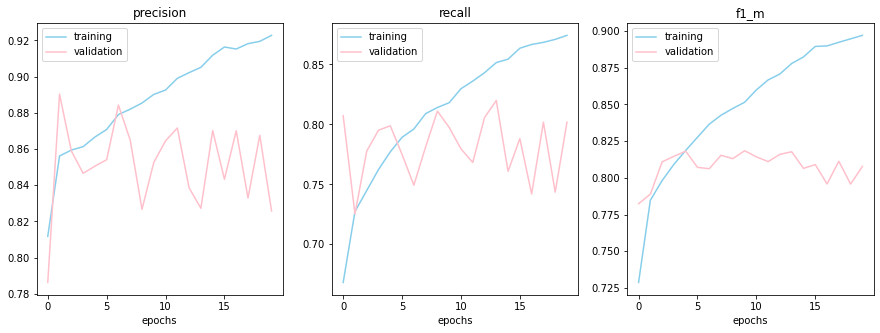

In [23]:
plot_graphs(multi_history, ['precision', 'recall', 'f1_m'])

### 5. Evaluacija modela

In [42]:
scores = multi_model.evaluate(X_test_transformed, y_test)
print('Loss: ', scores[0])
print('Precision: ', scores[1])
print('Recall: ', scores[2])
print('AUC:', scores[3])
print('F1: ', scores[4])

280/280 [==============================] - 1s 2ms/step - loss: 0.4236 - precision: 0.8267 - recall: 0.8003 - auc: 0.9242 - f1_m: 0.8125
Loss:  0.42361512780189514
Precision:  0.8267117738723755
Recall:  0.8002520203590393
AUC: 0.924227774143219
F1:  0.8125165700912476


Predviđanje:

In [40]:
y_predicted = multi_model.predict(X_test_transformed)
y_labels = y_predicted.round()
cf = multilabel_confusion_matrix(y_test, y_labels)

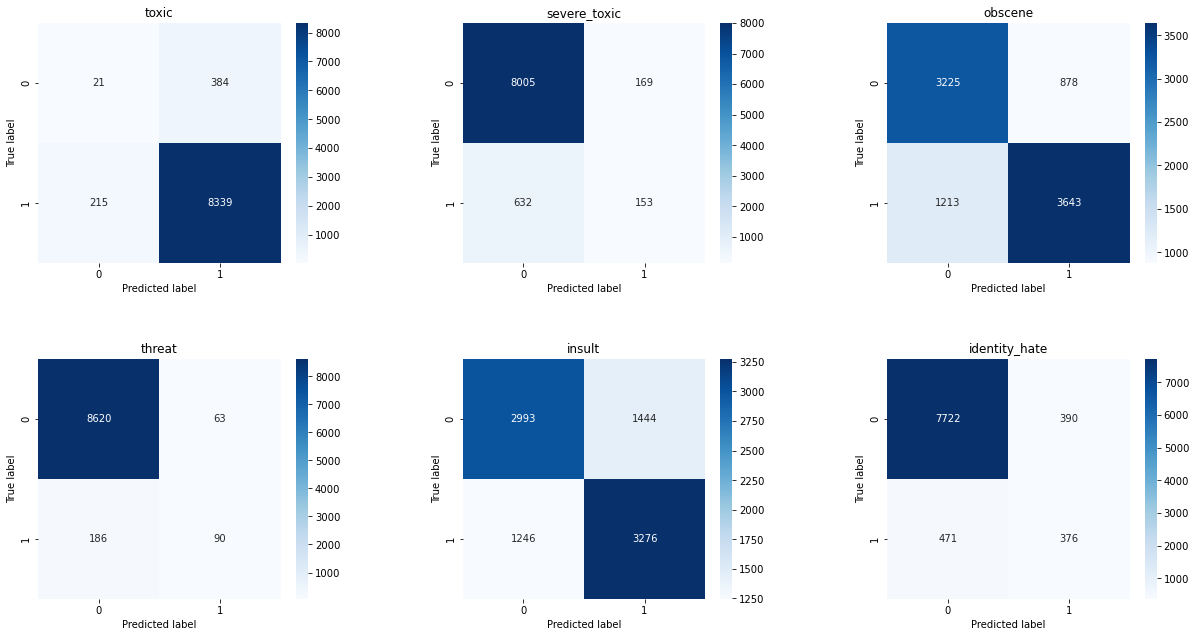

In [41]:
plot_cf(cf, 'multi', labels)

**Model ne predviđa dobro za klase severe_toxic, threat, i identity hate, što i jesu klase sa najmanjim brojem podataka**

In [27]:
print('Brojnost po klasama na test skupu:')
print(get_label_counts(y_test, labels))

Brojnost po klasama na test skupu:
{'toxic': 8554, 'severe_toxic': 785, 'obscene': 4856, 'threat': 276, 'insult': 4522, 'identity_hate': 847}


In [28]:
# print(metrics.classification_report(y_test, y_labels,target_names=labels))

Preciznost, odziv i F1 mera za svaku klasu:

In [43]:
precisions, recalls, f1_scores = get_prec_rec_f1(cf, labels)

In [44]:
precisions

{'toxic': 0.96,
 'severe_toxic': 0.48,
 'obscene': 0.81,
 'threat': 0.59,
 'insult': 0.69,
 'identity_hate': 0.49}

In [45]:
recalls

{'toxic': 0.97,
 'severe_toxic': 0.19,
 'obscene': 0.75,
 'threat': 0.33,
 'insult': 0.72,
 'identity_hate': 0.44}

In [46]:
f1_scores

{'toxic': 0.96,
 'severe_toxic': 0.27,
 'obscene': 0.78,
 'threat': 0.42,
 'insult': 0.7,
 'identity_hate': 0.46}

In [47]:
new_comments = ['i will kill you', 'fuck you piece of shit', 'go die', 'i hate jews', 'asshole']
new = to_sequence(new_comments, 100, tokenizer)

probs = multi_model.predict(new)

predictions = []

for prob in probs:
    rounded = [round(p) for p in prob]
    predictions.append(rounded)
        
model_preds = pd.DataFrame(predictions, columns=labels)
model_preds['comment'] = new_comments

In [48]:
print('Predvidjanja za nove komentare: ')
model_preds

Predvidjanja za nove komentare: 


,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment
0,1,0,0,1,0,0,i will kill you
1,1,0,1,0,1,0,fuck you piece of shit
2,1,0,0,0,0,0,go die
3,1,0,0,0,0,1,i hate jews
4,1,0,1,0,1,0,asshole


### Čuvanje modela

In [49]:
multi_model.save('models/multi_model.h5')

In [50]:
# model = keras.models.load_model('models/multi_model.h5', custom_objects={"f1_m": f1_m})
# model.get_config()